# Assignment 10 - UNet

In this assignement we are going to program our own UNet network (https://arxiv.org/pdf/1505.04597.pdf) which is a simple but powerful one. This network is made to produce a segmentation map. This segmentation map can be a little bit smaller than the true map but keep the same spatial structure. This map however is composed of several layers, one per class. The goal for the network is to activate pixel-wisely a layer if the pixel are representing the object of the layer.

In [1]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png", width=700)

The network look this way. The descending part is simply made out of convolution layer and pooling, easy peasy. This part of the network allow a move from the "Where?" information to the "What?" information. Then the informations are spatially dilated through a so called "transpose convolution" looking like a convoltuion mixed with an inverse pooling and then you convolute. as I sayed above, there is one layer of exit per class, don't trust the drawing, the initial version of this network was only design to say yes or not (That why there is two output layer)

In [2]:
Image(url= "https://miro.medium.com/max/3200/0*mk6U6zQDuoQLK7Ca", width=700)

After each big step of convolution, the informations are stacked to the last part of the network (grey arrow) reinjecting this way the "Where?" information.

# 8.1

Yo have to reproduce this network by yourself. The images takken for this work come from the PascalVOC database (http://host.robots.ox.ac.uk/pascal/VOC/). Here you inject RGB images into your network and out a "cube" of maps. The label of the data are on the shape of images with one channel, the background is represented by 0 and the differents class by a unique label (all the pixel filled out of ones are representing a plan typically.)

You have to use dtype=torch.float32 for the images and dtype=torch.long for the mask and every thing should run perfectly. Use also the criterion to use should be criterion = nn.CrossEntropyLoss() because he can understand the type of label injected (https://pytorch.org/docs/stable/nn.html#torch.nn.CrossEntropyLoss). 

Try to work on this early, the training can be slow (like 1h for 50 epoch ; batch : 100)

In [3]:
import numpy as np
import sys
np.set_printoptions(threshold=sys.maxsize)
import torch
import torchvision
import torch.nn as nn
from torch import optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
from tqdm import tqdm
from torch.autograd import Function
from torch.utils.data import DataLoader, random_split
from matplotlib import pyplot as plt
from PIL import Image
import time
import copy
import os

torch.__version__

'1.3.1'

In [0]:
class VOCSegLoader(torchvision.datasets.VOCSegmentation):
    def __init__(self, 
                 root, 
                 year='2012',
                 image_set='train',
                 download=False,
                 transform=None,
                 target_transform=None,
                 transforms=None):
        
        super(VOCSegLoader, self).__init__(root, year, image_set, download, transform, target_transform, transforms)


    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is the image segmentation.
        """
        img = Image.open(self.images[index]).convert('RGB')
        target = Image.open(self.masks[index])
        
        target = np.array(target)
        target[target == 255] = 0
        target = Image.fromarray(target)
        
        if self.transforms is not None:
            img, target = self.transforms(img, target)
        
        target = torch.as_tensor(np.asarray(target, dtype=np.uint8), dtype=torch.long)
        return img, target          

In [5]:
n_epochs = 3
batch_size = 2
#batch_size_train = 100
#batch_size_val = 100
learning_rate = 0.001
momentum = 0.9
log_interval = 10
image_size = (64, 85)


transform_data = torchvision.transforms.Compose([torchvision.transforms.Resize(image_size), 
                                                 torchvision.transforms.ToTensor()])
transform_label = torchvision.transforms.Compose([torchvision.transforms.Resize(image_size, interpolation=0)])



image_datasets = {x: VOCSegLoader('./data', year='2012', image_set='train', download=True,
                    transform=transform_data, target_transform=transform_label)
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size = batch_size)
              for x in ['train', 'val']}



dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Using downloaded and verified file: ./data/VOCtrainval_11-May-2012.tar
Using downloaded and verified file: ./data/VOCtrainval_11-May-2012.tar


<class 'torch.Tensor'> torch.Size([3, 64, 85])
<class 'torch.Tensor'> torch.Size([64, 85])


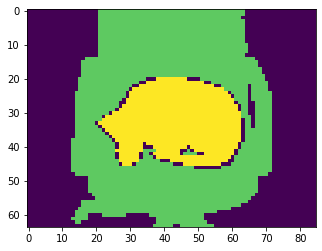

In [6]:
image, target = image_datasets['train'][2]
print(type(image), image.size())
print(type(target), target.size())

plt.figure()
plt.imshow(np.asarray(target))
plt.show()

def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.figure(figsize=(20, 20))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs):
    out = torchvision.utils.make_grid(inputs)
    #print(out.numpy())
    imshow(out)

In [0]:
# NETWORK
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, 3, padding=1)

        self.maxpool = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, 3, padding=1)

        self.conv5 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv6 = nn.Conv2d(256, 256, 3, padding=1)

        self.conv7 = nn.Conv2d(256, 512, 3, padding=1)
        self.conv8 = nn.Conv2d(512, 512, 3, padding=1)

        self.conv9 = nn.Conv2d(512, 1024, 3, padding=1)
        self.conv10 = nn.Conv2d(1024, 1024, 3, padding=1)

        self.upconv1 = nn.ConvTranspose2d(1024, 512, 3, stride=2)
        # cat
        self.conv11 = nn.Conv2d(1024, 512, 3, padding=1)
        self.conv12 = nn.Conv2d(512, 512, 3, padding=1)

        self.upconv2 = nn.ConvTranspose2d(512, 256, 3, stride=2)
        # cat
        self.conv13 = nn.Conv2d(512, 256, 3, padding=1)
        self.conv14 = nn.Conv2d(256, 256, 3, padding=1)

        self.upconv3 = nn.ConvTranspose2d(256, 128, 3, stride=2)
        # cat
        self.conv15 = nn.Conv2d(256, 128, 3, padding=1)
        self.conv16 = nn.Conv2d(128, 128, 3, padding=1)

        self.upconv4 = nn.ConvTranspose2d(128, 64, 3, stride=2)
        # cat
        self.conv17 = nn.Conv2d(128, 64, 3, padding=1)
        self.conv18 = nn.Conv2d(64, 64, 3, padding=1)

        self.upconvEXTRA = nn.ConvTranspose2d(64, 64, 3, stride=2)

        self.conv19 = nn.Conv2d(64, 21, 1)

    def forward(self, x):
        a = F.relu(self.conv1(x))
        a = self.maxpool(F.relu(self.conv2(a)))

        b = F.relu(self.conv3(a))
        b = self.maxpool(F.relu(self.conv4(b)))

        c = F.relu(self.conv5(b))
        c = self.maxpool(F.relu(self.conv6(c)))

        d = F.relu(self.conv7(c))
        d = self.maxpool(F.relu(self.conv8(d)))

        e = F.relu(self.conv9(d))
        e = F.relu(self.conv10(e))

        f = self.upconv1(e)
        #print(d.shape,f.shape)  #torch.Size([100, 512, 3, 3])
        f = f[:,:,2:6,2:7]
        f = torch.cat((d,f),dim=1)
        f = F.relu(self.conv11(f))
        f = F.relu(self.conv12(f))

        g = self.upconv2(f)
        #print(c.shape,g.shape)
        g = g[:,:,1:,1:]
        g = torch.cat((c,g),dim=1)
        g = F.relu(self.conv13(g))
        g = F.relu(self.conv14(g))

        h = self.upconv3(g)
        #print(b.shape,h.shape)
        h = h[:,:,1:,:]
        h = torch.cat((b,h),dim=1)
        h = F.relu(self.conv15(h))
        h = F.relu(self.conv16(h))

        i = self.upconv4(h)
        #print(a.shape,i.shape)
        i = i[:,:,1:,1:]
        i = torch.cat((a,i),dim=1)
        i = F.relu(self.conv17(i))
        i = F.relu(self.conv18(i))

        j = self.upconvEXTRA(i)
        #print(j.shape)
        j = j[:,:,1:,:]

        k = self.conv19(j)
        
        return j

model = Net()

In [0]:
# TRAIN FUNCTION
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [0]:
model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [111]:
model = train_model(model, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=20)

Epoch 1/20
----------
train Loss: 2.0183 Acc: 4001.8538
val Loss: 1.3999 Acc: 4073.1366

Epoch 2/20
----------
train Loss: 1.3415 Acc: 4073.1366
val Loss: 1.3460 Acc: 4073.1366

Epoch 3/20
----------
train Loss: 1.3072 Acc: 4073.1366
val Loss: 1.3163 Acc: 4073.1366

Epoch 4/20
----------
train Loss: 1.2836 Acc: 4073.1366
val Loss: 1.2945 Acc: 4073.1366

Epoch 5/20
----------
train Loss: 1.2702 Acc: 4073.1366
val Loss: 1.2838 Acc: 4073.1366

Epoch 6/20
----------
train Loss: 1.2640 Acc: 4073.1366
val Loss: 1.2788 Acc: 4073.1366

Epoch 7/20
----------
train Loss: 1.2604 Acc: 4073.1366


KeyboardInterrupt: ignored

In [0]:
# VISUALIZE PREDICTION

## 8.2
Once you have done that, we want you to redesign a network where you remove to reinjection link (grey arrow on the drawing). You can remove the both from your choice just try and tell us if it's still working and why.

In [0]:
#TODO

## 8.3 BONUSTOCOME